# Fused-Gromov-Wasserstein距離による最適輸送を用いて、対応する項目の検索クエリをノードとするレイアウト・グラフと、２次元に項目（単語や文章の塊）が配置された帳票の間のアラインメントを行う


## 例題

### レイアウト・グラフ

    0:営業許可証
        |
    1:営業者住所 ─ 2:*
        |             |
    3:営業者氏名 ─ 4:*
        | 
    5:*
        | 
    6:有効期限
        | 
    7:00年00月00日


### 帳票

    0:"営業許可証"

    1:"営業者住所"    2:"神奈川県横浜市西区みなとみらい"
    3:"営業者氏名"    4:"日鉄太郎"

    5:"余分な文章が長々と書かれている部分が\n入っていることってありますよね。"

    6:"有効期限"
    7:"令和10年4月14日"





# ライブラリの準備

In [ ]:
%%capture
!apt install graphviz libgraphviz-dev
!pip install pot networkx pygraphviz
!pip install transformers fugashi ipadic
!pip install japanize-matplotlib

# Sentence-BERTモデル定義

In [ ]:
from transformers import BertJapaneseTokenizer, BertModel
import torch


class SentenceBertJapanese:
    def __init__(self, model_name_or_path, device=None):
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_or_path)
        self.model = BertModel.from_pretrained(model_name_or_path)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.inference_mode()
    def encode(self, sentences, batch_size=8):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest", 
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)

In [ ]:
text_model = SentenceBertJapanese("sonoisa/sentence-bert-base-ja-mean-tokens")

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/730 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BertJapaneseTokenizer'.


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

# 実験データ定義

レイアウト・グラフの定義

    0:営業許可証
        |
    1:営業者住所 ─ 2:*
        |             |
    3:営業者氏名 ─ 4:*
        | 
    5:*
        | 
    6:有効期限
        | 
    7:00年00月00日

定義方法

- ノード: 対応する帳票上の項目を検索するためのクエリ。BM25等でヒットする検索キーワードであること。検索キーワードが思い浮かばない項目である場合はワイルドカード"*"とする。
- エッジ: 対応する帳票において隣り合う項目であればそのノード同士をエッジで結ぶ（マンハッタン距離でみて近い項目を結ぶ）。それ以外は結ばない。

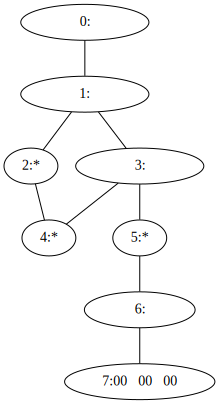

In [ ]:
from IPython.display import display_svg
import networkx as nx
import graphviz


graph = nx.Graph()
nx.add_path(graph, [0, 1, 2])
nx.add_path(graph, [1, 3, 4])
nx.add_path(graph, [3, 5, 6, 7])
nx.add_path(graph, [2, 4])

node_labels = ["営業許可証", "営業者住所", "*", 
               "営業者氏名", "*", "*", "有効期限", "00年00月00日", 
               ]
label_map = {node: f"{node}:{label}" for node, label in zip(graph.nodes, node_labels)}

graphviz.Source(nx.nx_agraph.to_agraph(nx.relabel_nodes(graph, label_map)))

グラフ内の距離行列

グラフのホップ数を用いる

In [ ]:
import numpy as np

node_count = len(graph.nodes)

C1 = np.full((node_count, node_count), node_count, dtype=np.float32)


for from_index, tos in nx.all_pairs_shortest_path_length(graph):
    for to_index, distance in tos.items():
        C1[from_index, to_index] = distance

C1

array([[0., 1., 2., 2., 3., 3., 4., 5.],
       [1., 0., 1., 1., 2., 2., 3., 4.],
       [2., 1., 0., 2., 1., 3., 4., 5.],
       [2., 1., 2., 0., 1., 1., 2., 3.],
       [3., 2., 1., 1., 0., 2., 3., 4.],
       [3., 2., 3., 1., 2., 0., 1., 2.],
       [4., 3., 4., 2., 3., 1., 0., 1.],
       [5., 4., 5., 3., 4., 2., 1., 0.]], dtype=float32)

帳票の定義

    営業許可証

    営業者住所    神奈川県横浜市西区みなとみらい
    営業者氏名    日鉄太郎

    有効期限
    令和10年4月14日


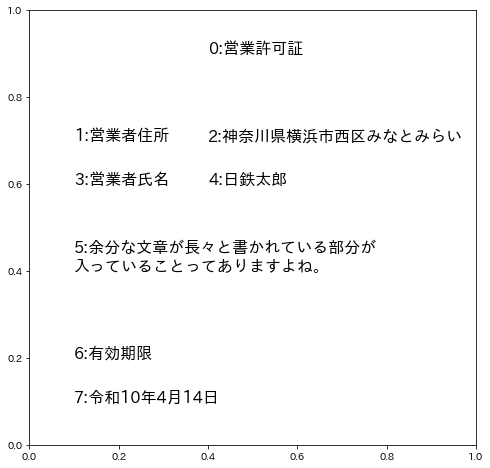

In [ ]:
import matplotlib.pyplot as pl
import japanize_matplotlib


form_items = [
              {"text":"営業許可証", "xy":(0.4, 0.9)},
              {"text":"営業者住所", "xy":(0.1, 0.7)},
              {"text":"神奈川県横浜市西区みなとみらい", "xy":(0.4, 0.7)},
              {"text":"営業者氏名", "xy":(0.1, 0.6)},
              {"text":"日鉄太郎", "xy":(0.4, 0.6)},
              {"text":"余分な文章が長々と書かれている部分が\n入っていることってありますよね。", "xy":(0.1, 0.4)},
              {"text":"有効期限", "xy":(0.1, 0.2)},
              {"text":"令和10年4月14日", "xy":(0.1, 0.1)},
              ]

fig = pl.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
for i, item in enumerate(form_items):
    ax.text(item["xy"][0], item["xy"][1], f"{i}:" + item["text"], fontsize=16, horizontalalignment="left")

fig.show()

帳票内の距離

マンハッタン距離を用いる

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

item_count = len(form_items)

C2 = np.zeros((item_count, item_count), dtype=np.float32)

for i, item_i in enumerate(form_items):
    xyi = item_i["xy"]
    for j, item_j in enumerate(form_items):
        xyj = item_j["xy"]
        distance = cdist(np.array([xyi], dtype=np.float32), np.array([xyj], dtype=np.float32), metric="cityblock")
        # distance = cdist(np.array([xyi], dtype=np.float32), np.array([xyj], dtype=np.float32), metric="euclid")
        C2[i, j] = distance

C2

array([[0.        , 0.5       , 0.19999999, 0.59999996, 0.29999995,
        0.79999995, 1.        , 1.1       ],
       [0.5       , 0.        , 0.3       , 0.09999996, 0.39999998,
        0.29999998, 0.5       , 0.59999996],
       [0.19999999, 0.3       , 0.        , 0.39999998, 0.09999996,
        0.59999996, 0.8       , 0.9       ],
       [0.59999996, 0.09999996, 0.39999998, 0.        , 0.3       ,
        0.20000002, 0.40000004, 0.5       ],
       [0.29999995, 0.39999998, 0.09999996, 0.3       , 0.        ,
        0.5       , 0.70000005, 0.8       ],
       [0.79999995, 0.29999998, 0.59999996, 0.20000002, 0.5       ,
        0.        , 0.2       , 0.3       ],
       [1.        , 0.5       , 0.8       , 0.40000004, 0.70000005,
        0.2       , 0.        , 0.1       ],
       [1.1       , 0.59999996, 0.9       , 0.5       , 0.8       ,
        0.3       , 0.1       , 0.        ]], dtype=float32)

レイアウト・グラフのノード数と帳票の項目数は一致しなければならない。

In [ ]:
assert len(form_items) == len(node_labels), "レイアウト・グラフのノード数と帳票の項目数は一致しなければならない。"

レイアウト・グラフと帳票の間の距離

共通の尺度として、基本的に文ベクトルのコサイン距離を用いる。  
レイアウト・グラフのテキストが"*"（ワイルドカード）である場合、帳票のどのテキストとも距離が0なるようにする。

In [ ]:
form_sentence_vectors = text_model.encode([item["text"] for item in form_items])
form_sentence_vectors = (form_sentence_vectors / form_sentence_vectors.norm(dim=-1, keepdim=True)).numpy()

zero_sentence_vector = np.zeros((768,), dtype=np.float32)
graph_sentence_vectors = []

for node_text in node_labels:
    if node_text == "*":
        sentence_vector = zero_sentence_vector
    else:
        sentence_vector = text_model.encode([node_text])[0]
        sentence_vector = (sentence_vector / sentence_vector.norm()).numpy()
    graph_sentence_vectors.append(sentence_vector)

graph_sentence_vectors = np.stack(graph_sentence_vectors)

M = 1 - (graph_sentence_vectors @ form_sentence_vectors.T)

for i, node_text in enumerate(node_labels):
    if node_text == "*":
        M[i, :] = 0

M

array([[ 1.1920929e-07,  3.4579206e-01,  8.6697286e-01,  2.8756034e-01,
         7.9042923e-01,  8.6540902e-01,  7.2676492e-01,  9.0127987e-01],
       [ 3.4579194e-01, -1.1920929e-07,  9.0693498e-01,  1.6739148e-01,
         6.8828046e-01,  8.6367649e-01,  7.3611766e-01,  8.3444321e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.8756034e-01,  1.6739148e-01,  8.2537711e-01, -7.1525574e-07,
         7.2743708e-01,  8.7208104e-01,  7.7493298e-01,  8.7928259e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 7.2676480e-01,  7.3611760e-01,  8.5796094e-01,  7.7493298e-01,
         7.5787938e-01,  5.6888443e-01, -4.7683716e-07,  7

# アラインメントの実行

In [ ]:
import matplotlib.pyplot as pl
import numpy as np
import ot
from ot.gromov import gromov_wasserstein, fused_gromov_wasserstein

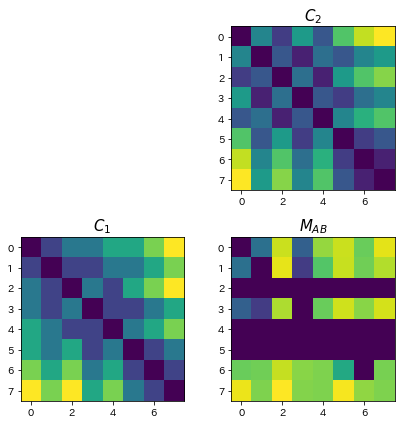

In [ ]:
pl.close(1)
pl.figure(1, (6, 6))
fs = 15
gs = pl.GridSpec(2, 2)

ax1 = pl.subplot(gs[1:, :1])
pl.imshow(C1, interpolation='nearest')
pl.title("$C_1$", fontsize=fs)
# ax1.set_aspect('auto')

ax2 = pl.subplot(gs[:1, 1:])
pl.imshow(C2, interpolation='nearest')
pl.title("$C_2$", fontsize=fs)
# ax2.set_aspect('auto')

ax3 = pl.subplot(gs[1:, 1:], sharex=ax2, sharey=ax1)
pl.imshow(M, interpolation='nearest')
pl.title("$M_{AB}$", fontsize=fs)
pl.tight_layout()
# ax3.set_aspect('auto')
pl.show()

In [ ]:
p = ot.unif(node_count)
q = ot.unif(item_count)

alpha = 0.5

# Fused Gromov-Wasserstein距離を用いた最適輸送計画
Gwg, logw = fused_gromov_wasserstein(M, C1, C2, p, q, loss_fun='square_loss', alpha=alpha, verbose=True, log=True)

# Wasserstein距離を用いた最適輸送計画
Got = ot.emd([], [], M)

# Gromov-Wasserstein距離を用いた最適輸送計画
Gg, log = gromov_wasserstein(C1, C2, p, q, loss_fun='square_loss', verbose=True, log=True)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.688061e+00|0.000000e+00|0.000000e+00
    1|2.150394e+00|2.500318e-01|5.376669e-01
    2|2.150394e+00|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.975469e+00|0.000000e+00|0.000000e+00
    1|4.580938e+00|8.612457e-02|3.945313e-01
    2|4.580938e+00|0.000000e+00|0.000000e+00


アラインメントの結果

- Fused-Gromov-Wasserstein: 項目の内容とレイアウトの両方の類似性を用いたアラインメント。これが最良であるはず。
- Wasserstein: 項目の内容の類似性のみを用いたアラインメント（レイアウト情報は用いない）
- Gromov-Wassertstein: レイアウトの類似性のみを用いたアラインメント（項目の内容情報は用いない)

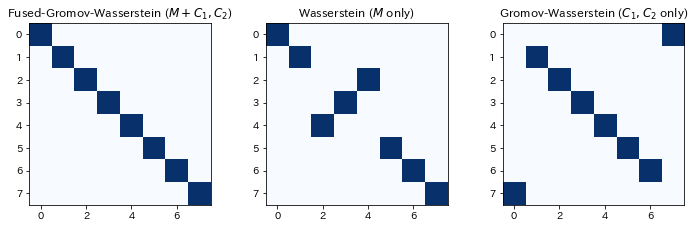

In [ ]:
cmap = 'Blues'
fs = 15
pl.figure(2, (10, 5))
pl.clf()

pl.subplot(1, 3, 1)
pl.imshow(Gwg, cmap=cmap, interpolation='nearest')
pl.title('Fused-Gromov-Wasserstein ($M+C_1,C_2$)')

pl.subplot(1, 3, 2)
pl.imshow(Got, cmap=cmap, interpolation='nearest')
pl.title('Wasserstein ($M$ only)')

pl.subplot(1, 3, 3)
pl.imshow(Gg, cmap=cmap, interpolation='nearest')
pl.title('Gromov-Wasserstein ($C_1,C_2$ only)')

pl.tight_layout()
pl.show()